In [ ]:
from common import *

In [ ]:
cc = db['chessData']['2023-10']
#chessCollection

In [ ]:
cc.estimated_document_count()

### Get ELO Distribution

In [99]:
def mongoResultToDf(mongoResult):
  resDf = pd.DataFrame(zip([item['_id'] for item in mongoResult], [item['count'] for item in mongoResult]), columns=['elo', 'count'])
  resDf.set_index('elo', inplace=True)
  return resDf


def plotDistributionDf(mongoDf, title, normalized=False, show=True, width=0.9):
  distPlot = mongoDf.plot(kind='bar', ylabel='Normalized Values' if normalized else 'Games Played', xlabel="Player's ELO", width=width)
  distPlot.set_title(label=f"Elo Distribution of {title.split('-')[-1]}", pad=30)
  distPlot.bar_label(distPlot.containers[0], fmt="{:.4f}" if normalized else "{:.0f}", padding=2, rotation=90, fontsize=8)
  if not normalized:
    distPlot.yaxis.set_major_formatter(tm_formatter)
  
  fig = distPlot.get_figure()
  fig.savefig(f'plots/distribution/{"norm" if normalized else "raw"}/{title}.png', dpi=300, facecolor='w', bbox_inches='tight')

  if not show:
    plt.close(fig)

### Counting each one individually 

In [ ]:
eloDistributionAgg = [
  {
    '$group': {
      '_id': {'$avg': ['$whiteElo', '$blackElo']},
      'count': {'$sum': 1}
    }
  },
  {
    '$addFields': {
      '_id': {'$ceil': '$_id'}
    }
  }
]

overallEloDistribution = list(cc.aggregate(eloDistributionAgg))

In [ ]:
distDict = plotMongoResult(overallEloDistribution)

### Binning

In [ ]:
list(cc.aggregate([ 
    { "$group": { 
        "_id": None,
        "maxw": { "$max": "$whiteElo" }, 
        "minw": { "$min": "$whiteElo" }, 
        "maxb": { "$max": "$blackElo" }, 
        "minb": { "$min": "$blackElo" }, 
    }}
]))

In [ ]:
binEloAg = {
    '$bucket': {
      "groupBy": {'$avg': ['$whiteElo', '$blackElo']},
      "boundaries": [x for x in range(400, 3401, 100)],
    }
  }


generalEloBins = list(cc.aggregate([binEloAg]))


In [74]:
generalEloDf = mongoResultToDf(generalEloBins)
generalEloDf.to_csv('distdata/general.csv', header=True)

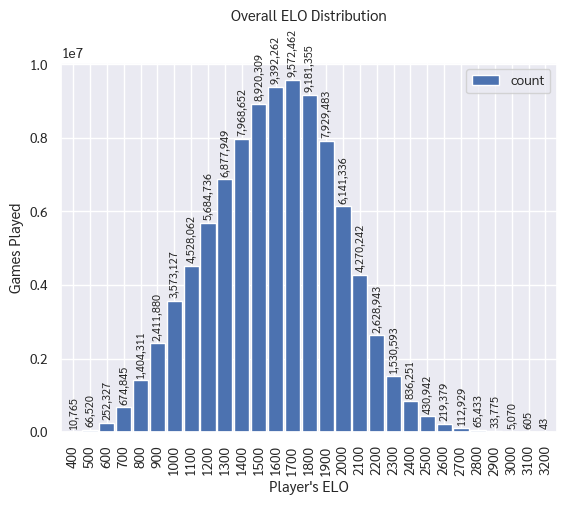

In [86]:
plotDistributionDf(generalEloDf, 'Overall ELO Distribution', normalized=False)

In [ ]:
normList = [round(value*normalizer, 4) for value, normalizer in zip(ebDict.values(), invList)]

## Opening-specific

### Gathering Data

In [81]:
focusedOpenings = ["Queen's Gambit Declined",
 'English Opening',
 'Modern Defense',
 "King's Pawn Game",
 'Italian Game',
 'Caro-Kann Defense',
 'Scandinavian Defense',
 'French Defense',
 "Queen's Pawn Game",
 'Sicilian Defense']

binEloAg = {
    '$bucket': {
      "groupBy": {'$avg': ['$whiteElo', '$blackElo']},
      "boundaries": [x for x in range(400, 3401, 100)],
    }
}

focusedDict = {}
for item in tqdm(focusedOpenings):
  matchOpeningAg = {'$match' : { 'opening' : item}} #'Sicilian Defense' } }
  focusedDict[item] = mongoResultToDf(list(cc.aggregate([matchOpeningAg, binEloAg])))

  0%|          | 0/10 [00:00<?, ?it/s]

In [84]:
focusedDict

{"Queen's Gambit Declined":        count
 elo         
 400       27
 500      232
 600     1419
 700     4943
 800    13681
 900    30379
 1000   54536
 1100   84978
 1200  122854
 1300  164659
 1400  213572
 1500  256069
 1600  295956
 1700  323409
 1800  317849
 1900  270290
 2000  203702
 2100  136785
 2200   80024
 2300   43739
 2400   23277
 2500   11802
 2600    5482
 2700    3138
 2800    2296
 2900    1853
 3000      87
 3100       7,
 'English Opening':        count
 elo         
 400      222
 500     1272
 600     3862
 700     8965
 800    20219
 900    37452
 1000   58225
 1100   81231
 1200  112247
 1300  150695
 1400  186591
 1500  233079
 1600  265503
 1700  301832
 1800  321832
 1900  299635
 2000  259711
 2100  202665
 2200  136052
 2300   85790
 2400   45966
 2500   21881
 2600   10859
 2700    5595
 2800    4153
 2900    2922
 3000     304
 3100       7,
 'Modern Defense':        count
 elo         
 400       92
 500      579
 600     2823
 700     9105
 800    20

#### Saving to CSVs

In [ ]:
itemno = 1
for key, value in tqdm(focusedDict.items()):
  plotDistributionDf(value / generalEloDf, f"{itemno}-{key}", normalized=True, show=False)
  itemno += 1

### Visualizing

#### Plotting Raw

In [96]:
itemno = 1
for key, value in tqdm(focusedDict.items()):
  plotDistributionDf(value, f"{itemno}-{key}", normalized=False, show=False)
  itemno += 1

  0%|          | 0/10 [00:00<?, ?it/s]

#### Plotting Normalized

In [100]:
itemno = 1
for key, value in tqdm(focusedDict.items()):
  plotDistributionDf(value / generalEloDf, f"{itemno}-{key}", normalized=True, show=False)
  itemno += 1

  0%|          | 0/10 [00:00<?, ?it/s]

In [104]:
itemno = 1
for key, value in tqdm(focusedDict.items()):
  value.to_csv(f'distdata/{itemno}-{key}.csv', header=True)
  itemno += 1

  0%|          | 0/10 [00:00<?, ?it/s]